# Distribution Visualization

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import os
import torch
import torch.functional as F

In [2]:
import matplotlib.pyplot as plt

def interp(x, xp, fp):
    """Custom interpolation function for PyTorch tensors."""
    i = torch.searchsorted(xp, x)
    i = torch.clamp(i, 1, len(xp) - 1)
    
    xp_left = xp[i - 1]
    xp_right = xp[i]
    fp_left = fp[i - 1]
    fp_right = fp[i]
    
    t = (x - xp_left) / (xp_right - xp_left)
    return fp_left + t * (fp_right - fp_left)

class Distribution:
    def __init__(self, bin_centers, counts):
        self.bin_centers = bin_centers
        self.counts = counts
        self.total_count = self.counts.sum()
        self.cumulative_counts = torch.cumsum(self.counts, dim=0)
    
    def pdf(self, x, bandwidth=None):
        if bandwidth is None:
            bandwidth = 0.15 * torch.std(self.bin_centers[1:-1]) * (self.total_count-2)**(-1/5)
        
        bin_centers = self.bin_centers.unsqueeze(1)
        
        if isinstance(x, float) or isinstance(x, int):
            x = torch.tensor([x])
        else:
            x = x.unsqueeze(0)
        
        kernel = torch.exp(-0.5 * ((x - bin_centers) / bandwidth)**2) / (bandwidth * torch.sqrt(torch.tensor(2 * torch.pi)))
        pdf = torch.sum(kernel * self.counts.unsqueeze(1), dim=0) / self.total_count
        
        return pdf

    def cdf(self, x):
        return interp(x, self.bin_centers, self.cumulative_counts / self.total_count)

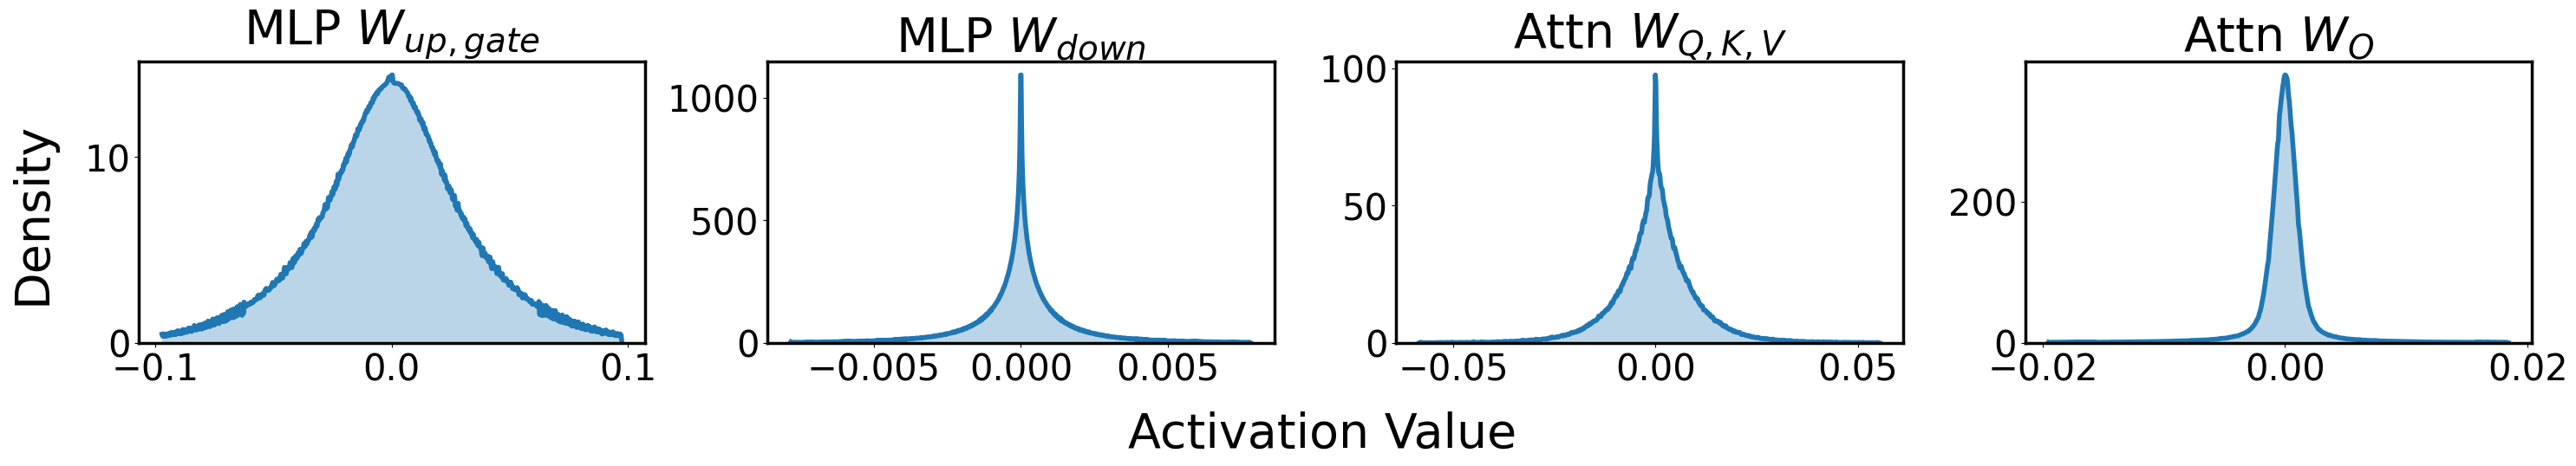

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import laplace

def load_histogram(model, layer, module, hist_type):
    hist_path = f"/home/jamesliu/release/TEAL/models/{model}/histograms/layer-{layer}/{module}/histograms.pt"
    hist = torch.load(hist_path)
    bin_centers = hist[f'{hist_type}_centers']
    counts = hist[hist_type]
    return bin_centers, counts

def plot_layer_distributions(model, layer):
    fig, axes = plt.subplots(1, 4, figsize=(30, 5))
    # fig.patch.set_alpha(0)
    
    components = [
        ('mlp', 'h1', "MLP $W_{up,gate}$", 'gaussian'),
        ('mlp', 'h2', "MLP $W_{down}$", 'laplacian'),
        ('self_attn', 'h1', "Attn $W_{Q,K,V}$", 'gaussian'),
        ('self_attn', 'h2', "Attn $W_O$", 'laplacian')
    ]
    
    for idx, (ax, (module, hist_type, label, fit_type)) in enumerate(zip(axes, components)):
        bin_centers, counts = load_histogram(model, layer, module, hist_type)
        dist = Distribution(bin_centers, counts)
        
        x = torch.linspace(bin_centers[1], bin_centers[-2], 1000)
        pdf = dist.pdf(x)
        bin_width = (x[1] - x[0]).item()
        
        # Plot original data
        ax.plot(x.numpy(), pdf.numpy(), linewidth=4)
        ax.bar(x, pdf, width=bin_width, alpha=0.3)
        
        ax.set_title(label, fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=30)
        
        for spine in ax.spines.values():
            spine.set_linewidth(2.5)

        # ax.patch.set_alpha(0)
    
    fig.text(0.01, 0.55, 'Density', va='center', rotation='vertical', fontsize=40)
    fig.text(0.515, 0.01, 'Activation Value', ha='center', fontsize=40)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.06, right=0.98, bottom=0.25, top=0.9)
    plt.show()

plot_layer_distributions("Llama-2-7B", 0)